In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Load text helpers
import text_helpers

sess = tf.Session()

In [5]:
# 保存先のフォルダが存在しない場合は作成
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

In [6]:
batch_size = 200            # このモデルのバッチサイズ
embedding_size = 50        # 単語の埋め込みサイズ
vocabulary_size = 2000      # トレーニングの対象となる単語の数
generations = 50000         # トレーニングの実行回数
model_learning_rate = 0.05   # 学習率

num_sampled = int(batch_size/2) # 不正解サンプルの数
window_size = 3                 # 考慮の対象となる前後の単語の数

# トレーニングのチェックポイントを追加
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 1000

In [7]:
# ストップワードを設定
stops = stopwords.words('english')

# 同義語が見つかることを期待して、テストワードを6つ選択
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

In [8]:
# 映画レビューデータをロード
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# テキストを正規化
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# テキストには少なくとも3つの単語が含まれていなければならない
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]
print('Done.')

Loading Data
Normalizing Text Data
Done.


In [9]:
# データセットとディクショナリを構築
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# テキストワードのキーを取得
valid_examples = [word_dictionary[x] for x in valid_words]

Creating Dictionary


In [10]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[batch_size, 2*window_size])
y_target = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

Creating Model


In [11]:
# Lookup the word embedding
# Add together window embeddings:
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

In [12]:
# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                               stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))

In [13]:
# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [14]:
# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings})

In [15]:
# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
# Filter out sentences that aren't long enough:
text_data = [x for x in text_data if len(x)>=(2*window_size+1)]

In [17]:
# Run the CBOW model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='cbow')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(optimizer, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},' .format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'cbow_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 1000 : 9.593059539794922
Loss at step 2000 : 6.443571090698242
Loss at step 3000 : 5.720491409301758
Loss at step 4000 : 5.325740814208984
Loss at step 5000 : 5.32508659362793
Nearest to love: truly, human, must, turns, us,
Nearest to hate: long, silly, firsttime, bland, country,
Nearest to happy: starring, generation, breathtaking, window, bother,
Nearest to sad: smart, noir, life, virtually, moviegoers,
Nearest to man: whole, comedy, womans, entire, fun,
Nearest to woman: want, flicks, spark, stock, addition,
Model saved in file: /notebooks/temp/cbow_movie_embeddings.ckpt
Loss at step 6000 : 5.0205278396606445
Loss at step 7000 : 4.658677577972412
Loss at step 8000 : 4.822328090667725
Loss at step 9000 : 5.068964004516602
Loss at step 10000 : 4.665541172027588
Nearest to love: truly, must, turns, human, version,
Nearest to hate: long, silly, firsttime, bland, country,
Nearest to happy: starring, generation, bother, breathtaking, paid,
Nearest to sad: sm

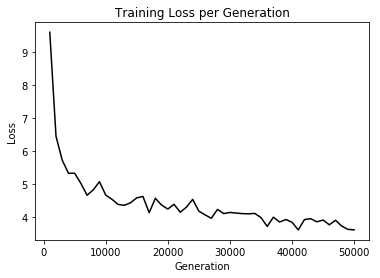

In [18]:
# Plot loss over time
plt.plot(loss_x_vec, loss_vec, 'k-')
plt.title('Training Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()